# Proposed Pseudocode

## Arduino Pseudocode
For when I do not rely on AI to write C++ code, basic pseudo understanding the basics of what I want for better interpretation (since understanding this will help when I am debugging more complicated tasks)

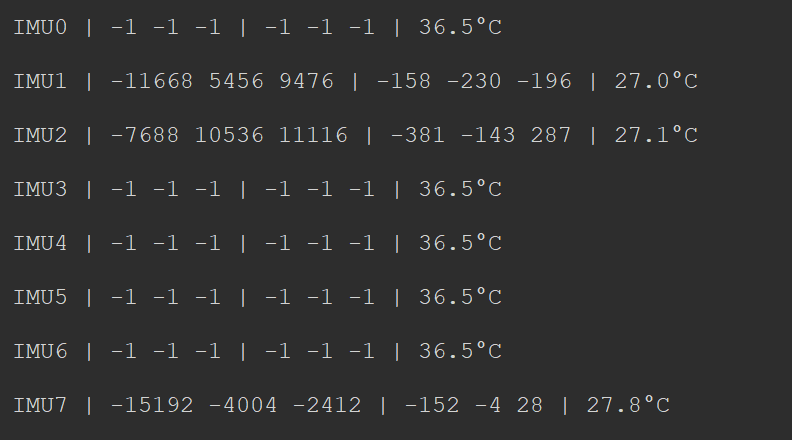

This is how the data shows in Python, but I feel that it can be cleaned much more in the ArduinoIDE.



1. Not displaying unsuccessful connects 
2. Handling the string text within the ArduinoIDE and then only shipping in the serial port what is necessary
3. Each IMU should have a tag that comes to where its position is: maybe in the form e.g. "IMU6 | ... | ... | ... | ID2" which indicates that it is the third sensor up from the base one (i.e. ID0)
4. Output that is clearer for analysis -- "{},{},{},{},{},{},ID2" -- with no whitespaces or stuff
5. What about gyroscope data

In [ ]:
# open serial port
# read all serial data
# find the channels that are sending data
    # if channel have data  
        # find which channels are sending data (there are 7 potential on the multiplexer)
        # assign those channels
        # stop displaying/checking other ports after 4 seconds of this (only outputting this locally and not to serial for analysis)
            # OR having a time delay in python for accessing the serial so that the data it reads is actually good
        # output desired data back into the serial in this format
            # {x_acc},{y_acc},{z_acc},{x_gyro},{y_gyro},{z_gyro},{ID}
            # 2.39, 6.53, 32.4, 1, 2, 3, 5  # indicating the 5th IMU connected
                                            # do not round any of the data points, I would like as detailed as possible as errors can easily accumulate 
                                            # and I would later like to analyse this with Kalman Filtering
            # the index of the sensors are defined initially OR sent off and defined in python (for the plotting mechanism)
    # else
        # wait for 2.5 seconds as a buffer period to verify that no data is being sent
        # print "There is no data in the serial\nClosing Program"
        # exit the for/while loop
        # close serial; end program

Make the exact prompt that I will give to AI (likely Claude/Gemini). I need to define every aspect of the components such as what specific modules. Then I will make the conversation public. 

- define all the components 
    - MPU6050
    - TCA9548A
    - AruduinoUNO
- specify specific model I am using (probably Claude Sonnet 4 or Gemimi pro 2.5)
- then I can review it

In Python, I would like to see the data as described as before so that it can be easily read into and extracted in only one line of code.

For optimisation, produce one model and then decide whether further optimisation should occur and whether it can work well with this laptop, as more computation will be occurring: 
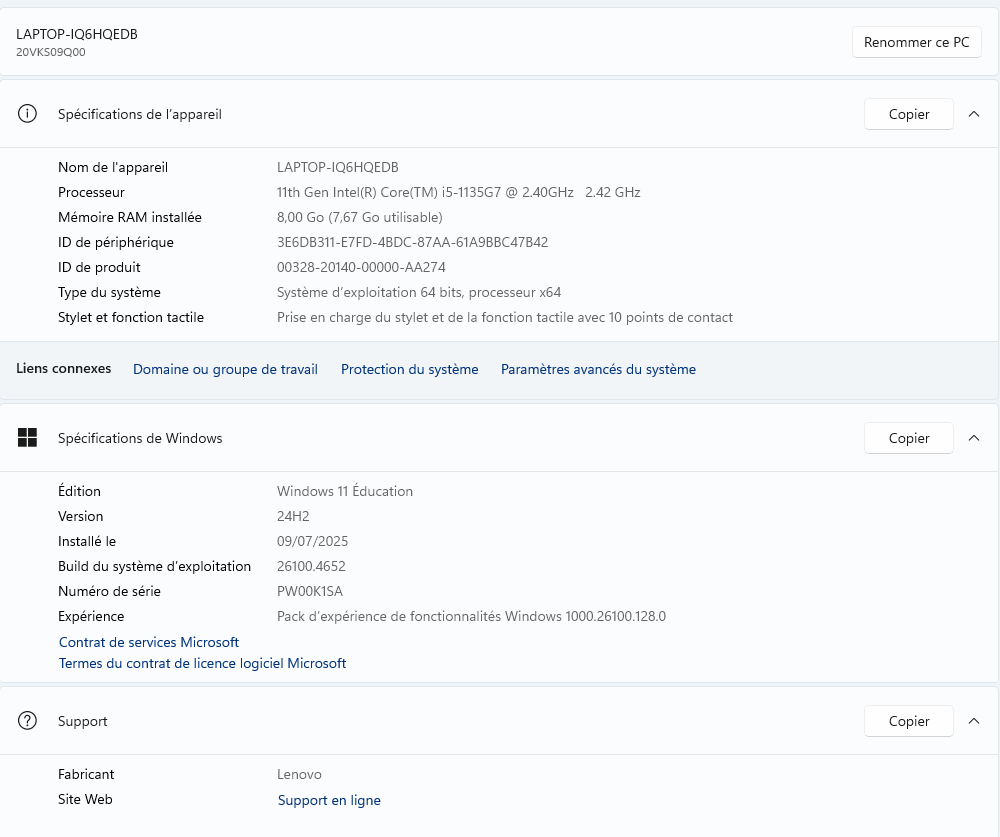

Whatever reduction in lag will allow me to do post-processing in python (such as Kalman Filtering) and so this code being as concise (but effective) as possible is useful and desirable.

## Arduino Code (C++)

In [ ]:
// Include the standard library for I2C communication.
#include <Wire.h>

// --- I2C Addresses ---
#define MPU6050_ADDR      0x68 // I2C address of the MPU6050
#define TCA_ADDRESS       0x70 // I2C address of the TCA9548A multiplexer

// --- MPU6050 Register Addresses ---
#define MPU6050_PWR_MGMT_1   0x6B
#define MPU6050_WHO_AM_I     0x75
#define MPU6050_ACCEL_XOUT_H 0x3B
#define MPU6050_GYRO_CONFIG  0x1B
#define MPU6050_ACCEL_CONFIG 0x1C

// --- Adjustable Delay ---
// The delay in milliseconds after each full cycle of sensor readings.
#define LOOP_DELAY_MS 150

// This array will keep track of which channels have a successfully connected MPU6050.
bool mpu_found[8] = {false, false, false, false, false, false, false, false};
bool any_sensor_found = false;

// Conversion factors for raw data to real-world units.
const float ACCEL_SCALE_FACTOR = 16384.0; // For ±2g range
const float GYRO_SCALE_FACTOR = 131.0;   // For ±250°/s range


void tca_select(uint8_t channel) {
  if (channel > 7) return;
  Wire.beginTransmission(TCA_ADDRESS);
  Wire.write(1 << channel);
  Wire.endTransmission();
}

void initializeMPU6050() {
  Wire.beginTransmission(MPU6050_ADDR);
  Wire.write(MPU6050_PWR_MGMT_1);
  Wire.write(0);
  Wire.endTransmission(true);

  Wire.beginTransmission(MPU6050_ADDR);
  Wire.write(MPU6050_ACCEL_CONFIG);
  Wire.write(0x00);
  Wire.endTransmission(true);
  
  Wire.beginTransmission(MPU6050_ADDR);
  Wire.write(MPU6050_GYRO_CONFIG);
  Wire.write(0x00);
  Wire.endTransmission(true);
}

bool testMPU6050Connection() {
  Wire.beginTransmission(MPU6050_ADDR);
  Wire.write(MPU6050_WHO_AM_I);
  Wire.endTransmission(false);
  Wire.requestFrom(MPU6050_ADDR, 1);
  return (Wire.read() == 0x68);
}

void readRawData(int16_t* ax, int16_t* ay, int16_t* az, int16_t* gx, int16_t* gy, int16_t* gz) {
  Wire.beginTransmission(MPU6050_ADDR);
  Wire.write(MPU6050_ACCEL_XOUT_H);
  Wire.endTransmission(false);
  Wire.requestFrom(MPU6050_ADDR, 14, true);

  *ax = (Wire.read() << 8 | Wire.read());
  *ay = (Wire.read() << 8 | Wire.read());
  *az = (Wire.read() << 8 | Wire.read());
  Wire.read(); Wire.read(); // Skip temperature data
  *gx = (Wire.read() << 8 | Wire.read());
  *gy = (Wire.read() << 8 | Wire.read());
  *gz = (Wire.read() << 8 | Wire.read());
}


void setup() {
  Serial.begin(115200);
  while (!Serial) { delay(10); }

  Wire.begin();
  Serial.println("Scanning for MPU6050 sensors...");

  for (uint8_t i = 0; i < 8; i++) {
    tca_select(i);
    if (testMPU6050Connection()) {
      Serial.print("MPU6050 found on channel: ");
      Serial.println(i);
      initializeMPU6050();
      mpu_found[i] = true;
      any_sensor_found = true;
    }
  }

  Serial.println("Scan complete.");

  if (!any_sensor_found) {
    Serial.println("No sensors found. Halting.");
    while (1) { delay(100); }
  }

  // --- NEW: Wait for the start command ---
  Serial.println("Waiting for 'begin program' command from Python...");
  String command = "";
  while (command != "begin program") {
    if (Serial.available() > 0) {
      command = Serial.readStringUntil('\n');
      command.trim(); // Remove any whitespace or newline characters
    }
  }
  Serial.println("Begin command received. Starting data stream...");
}

void loop() {
  int16_t accX_raw, accY_raw, accZ_raw;
  int16_t gyroX_raw, gyroY_raw, gyroZ_raw;

  for (uint8_t i = 0; i < 8; i++) {
    if (mpu_found[i]) {
      tca_select(i);
      readRawData(&accX_raw, &accY_raw, &accZ_raw, &gyroX_raw, &gyroY_raw, &gyroZ_raw);

      Serial.print(accX_raw / ACCEL_SCALE_FACTOR, 4);
      Serial.print(",");
      Serial.print(accY_raw / ACCEL_SCALE_FACTOR, 4);
      Serial.print(",");
      Serial.print(accZ_raw / ACCEL_SCALE_FACTOR, 4);
      Serial.print(",");
      Serial.print(gyroX_raw / GYRO_SCALE_FACTOR, 4);
      Serial.print(",");
      Serial.print(gyroY_raw / GYRO_SCALE_FACTOR, 4);
      Serial.print(",");
      Serial.print(gyroZ_raw / GYRO_SCALE_FACTOR, 4);
      Serial.print(",");
      Serial.println(i);
    }
  }
  
  delay(LOOP_DELAY_MS);
}